# Tactical Asset Allocation

In [1]:
%%capture
%reload_ext autoreload
%autoreload 2
%cd ..
%cd src

In [2]:
from pytaa.tools.data import get_strategy_price_data
from pytaa.strategy.static import STRATEGIES
from pytaa.strategy.strategies import StrategyPipeline
from pytaa.strategy.signals import Signal
from pytaa.backtest.positions import EqualWeights, RiskParity, vigilant_allocation
from pytaa.backtest.performance import Tearsheet
from pytaa.backtest.returns import Backtester
from pytaa.tools.utils import ledoit_wolf_constant_correlation


import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [3]:
start, end = "2011-01-01", "2023-05-01"
rebalance_dates = pd.bdate_range(start, end, freq="BM")

pipeline = StrategyPipeline(STRATEGIES)
data = get_strategy_price_data(pipeline, start, end).dropna()

In [51]:
all_strategies = []

# ivy
strategy = pipeline.ivy
strategy_data = data[strategy.risk_assets]
signals = Signal(strategy_data).sma_crossover(10).dropna()

weights = signals.apply(lambda x: np.where(x > 0, strategy.weights[0], 0))
weights.loc[:, strategy.safe_assets] = 1 - weights.sum(axis=1)
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# benchmark strategies
assets = strategy.get_tickers()
returns = data.pct_change().dropna().loc[:, assets]

ew = EqualWeights(assets, rebalance_dates).weights
rp = RiskParity(assets, rebalance_dates, returns).weights
all_strategies.append([ew, rp])

# robust asset allocation
strategy = pipeline.raab
strategy_data = data[strategy.get_tickers()]
signal_1 = Signal(strategy_data).classic_momentum(end=0).dropna()
signal_2 = Signal(strategy_data).sma_crossover(12, False).dropna()
cond_1 = np.where(signal_1[strategy.risk_assets].gt(signal_1[strategy.safe_assets].values), 1, 0)
cond_2 = np.where(strategy_data.reindex(signal_2.index) > signal_2, 1, 0)[:,:-1]
final_signal = cond_1 + cond_2
cash = np.atleast_2d(len(strategy.risk_assets) - np.sum(final_signal / 2, 1)).T
weights = pd.DataFrame(np.hstack([final_signal, cash]), index=signal_1.index, columns=signal_1.columns)
weights = weights.div(weights.sum(axis=1).values.reshape(-1, 1))
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# vigilant asset allocation g12
strategy = pipeline.vaag12
strategy_data = data[strategy.get_tickers()]
signal = Signal(strategy_data).momentum_score()
weights = pd.concat([x for x in signal.apply(lambda x: vigilant_allocation(x, strategy.risk_assets, strategy.safe_assets), axis=1)])
weights.index = signal.index
weights.columns.name = "ID"
all_strategies.append(weights.stack().rename(strategy.tag).to_frame())

# concat all strats
all_strategies = reduce(lambda x, y: x.join(y, how="outer"), all_strategies).fillna(0)

In [52]:
bt = Backtester(all_strategies, "USD")
port_total_returns = bt.run(return_type="total")
port_total_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12
Date,,,,,
2022-12-30,1.590742,1.488830,1.094620,1.479556,2.131866
2023-01-31,1.595264,1.564587,1.116819,1.562489,2.150892
2023-02-28,1.567305,1.513904,1.115594,1.519540,2.064711
2023-03-31,1.588445,1.529862,1.124882,1.532666,2.072951
2023-04-28,1.602002,1.538682,1.129199,1.558457,2.100156


In [53]:
port_price_returns = bt.run(return_type="price")
port_price_returns.add(1).cumprod().tail()

,IVY,EW,RP,RAAB,VAAG12
Date,,,,,
2022-12-30,1.375769,1.222701,1.006578,1.200181,1.839867
2023-01-31,1.379679,1.284917,1.026992,1.267455,1.856288
2023-02-28,1.352819,1.242001,1.022424,1.231579,1.778698
2023-03-31,1.367064,1.250713,1.027908,1.239175,1.780831
2023-04-28,1.375816,1.256549,1.027936,1.258937,1.803160


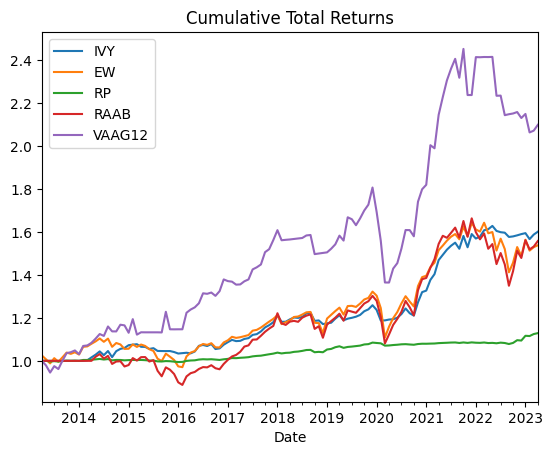

In [54]:
port_total_returns.add(1).cumprod().plot(title="Cumulative Total Returns");

In [56]:
Tearsheet(port_total_returns).summary(ann_factor=252)

,IVY,EW,RP,RAAB,VAAG12
#obs,121.000000,121.000000,121.000000,121.000000,121.000000
#years,14.484127,14.484127,14.484127,14.484127,14.484127
Total Return,0.602002,0.538682,0.129199,0.558457,1.100156
Annual. Return,0.033071,0.030199,0.008424,0.031107,0.052564
Volatility,0.235482,0.416086,0.057443,0.475042,0.553445
MaxDD,-0.056752,-0.161914,-0.014299,-0.188793,-0.245014
Skewness,0.176266,-0.735076,1.178707,-0.364915,-0.359855
Kurtosis,4.698189,5.699182,10.981297,4.243468,5.312247
Sharpe Ratio,4.292125,2.369245,4.435975,2.185441,3.076422
StdErr,0.265362,0.280040,0.244445,0.271239,0.276860
